In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

In [2]:
data_dir = os.path.dirname(os.path.dirname(os.getcwd()))
data_dir = os.path.join(data_dir, "dataset")
data_transformed = pd.read_excel(f"{data_dir}/data_transformed.xlsx", sheet_name="Sheet1")

In [3]:
columns = ["NMHC(GT)", "NOx(GT)", "CO(GT)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "NO2(GT)", "PT08.S4(NO2)", "PT08.S5(O3)"]

data_transformed = data_transformed[columns]
data_transformed.head()

,NMHC(GT),NOx(GT),CO(GT),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,20.673444,137.174844,0.473975,0.441183,0.811790,0.432234,0.643497,0.640258
1,20.558514,134.894175,0.466248,0.176077,1.176723,0.266791,0.358282,-0.005912
2,20.478471,135.959147,0.468824,0.130797,1.071902,0.440112,0.349185,0.216773
3,20.450300,137.371967,0.468824,0.157089,0.922823,0.503139,0.411793,0.499643
4,20.340964,135.959147,0.461097,-0.172285,1.273779,0.455869,0.211127,0.295561


In [4]:
# Gamma Regression: Metropolis-Hastings
def gamma_posterior(alpha, beta, y):
    likelihood = np.sum(gamma.logpdf(y, a=alpha, scale=1/beta))
    prior_alpha = -0.5 * (alpha - 2)**2  # Weak prior around 2
    prior_beta = -0.5 * (beta - 2)**2   # Weak prior around 2
    return likelihood + prior_alpha + prior_beta

def metropolis_gamma(y, iterations=1000, step_alpha=0.002, step_beta=0.002):
    alpha, beta = 2.0, 2.0
    samples = []
    trace_alpha, trace_beta = [], []  # Initialize traces for alpha and beta
    acceptance_count = 0  # Initialize acceptance counter

    for t in range(iterations):
        alpha_new = abs(alpha + np.random.normal(0, step_alpha))
        beta_new = abs(beta + np.random.normal(0, step_beta))

        posterior_current = gamma_posterior(alpha, beta, y)
        posterior_new = gamma_posterior(alpha_new, beta_new, y)

        acceptance_ratio = np.exp(posterior_new - posterior_current)

        if np.random.rand() < acceptance_ratio:
            alpha, beta = alpha_new, beta_new
            acceptance_count += 1

        samples.append((alpha, beta))
        trace_alpha.append(alpha)
        trace_beta.append(beta)

        # Print acceptance rate every 100 iterations
        if (t + 1) % 100 == 0:
            print(f"Iteration {t + 1}: Acceptance Rate = {acceptance_count / (t + 1):.2f}")

    # Plot the trace for alpha and beta
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(trace_alpha, label='Alpha')
    plt.title('Trace Plot for Alpha')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(trace_beta, label='Beta')
    plt.title('Trace Plot for Beta')
    plt.xlabel('Iteration')
    plt.ylabel('Beta')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # Plot the acceptance rate progression
    acceptance_rates = [np.sum(np.diff(trace_alpha[:i]) != 0) / i for i in range(1, len(trace_alpha))]
    plt.figure()
    plt.plot(acceptance_rates)
    plt.title("Acceptance Rate Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Acceptance Rate")
    plt.show()

    return np.array(samples)

In [5]:
# Extract features for Gamma regression
# data_nox = data_transformed.copy()
# data_nox["NOx(GT)"] = data_transformed["NOx(GT)"].replace(0,data_transformed["NOx(GT)"].mean(axis=0))
y_gamma = data_transformed[['NMHC(GT)', 'NOx(GT)']].values
samples_gamma = {}

# # Perform Gamma regression
print(f"[Info:] Performing Gamma Regression")

[Info:] Performing Gamma Regression


[Info:] Performing Gamma Regression on 'NMHC(GT)'
Iteration 100: Acceptance Rate = 0.48
Iteration 200: Acceptance Rate = 0.54
Iteration 300: Acceptance Rate = 0.51
Iteration 400: Acceptance Rate = 0.51
Iteration 500: Acceptance Rate = 0.51
Iteration 600: Acceptance Rate = 0.50
Iteration 700: Acceptance Rate = 0.50
Iteration 800: Acceptance Rate = 0.49
Iteration 900: Acceptance Rate = 0.47
Iteration 1000: Acceptance Rate = 0.46
Iteration 1100: Acceptance Rate = 0.44
Iteration 1200: Acceptance Rate = 0.44
Iteration 1300: Acceptance Rate = 0.43
Iteration 1400: Acceptance Rate = 0.42
Iteration 1500: Acceptance Rate = 0.42
Iteration 1600: Acceptance Rate = 0.41
Iteration 1700: Acceptance Rate = 0.41
Iteration 1800: Acceptance Rate = 0.40
Iteration 1900: Acceptance Rate = 0.40
Iteration 2000: Acceptance Rate = 0.40
Iteration 2100: Acceptance Rate = 0.40
Iteration 2200: Acceptance Rate = 0.40
Iteration 2300: Acceptance Rate = 0.39
Iteration 2400: Acceptance Rate = 0.39
Iteration 2500: Accepta

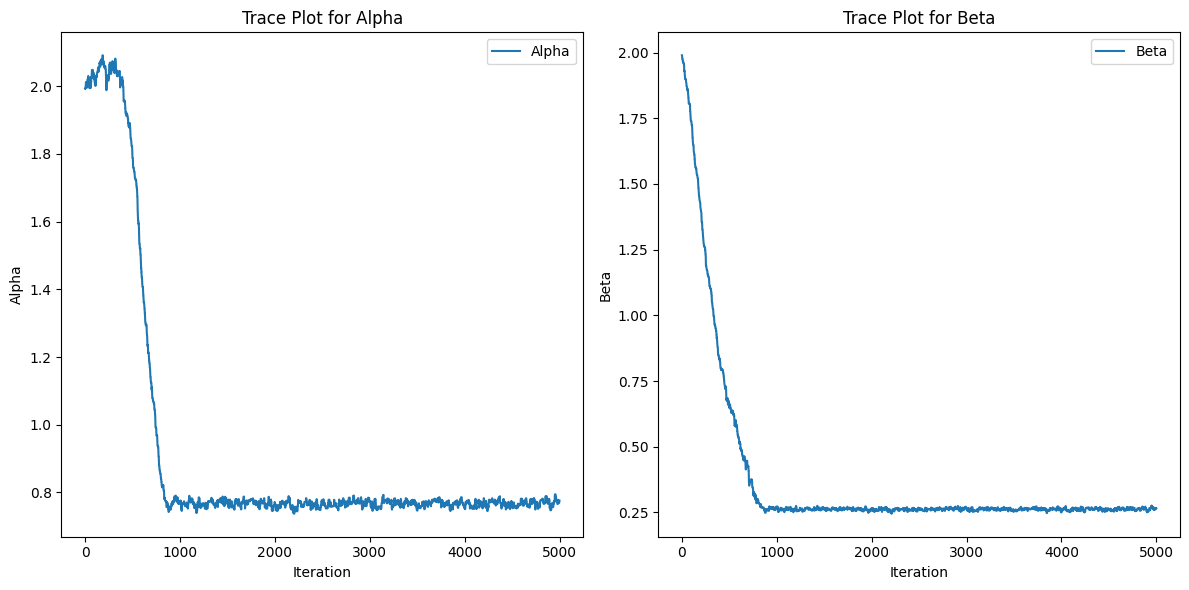

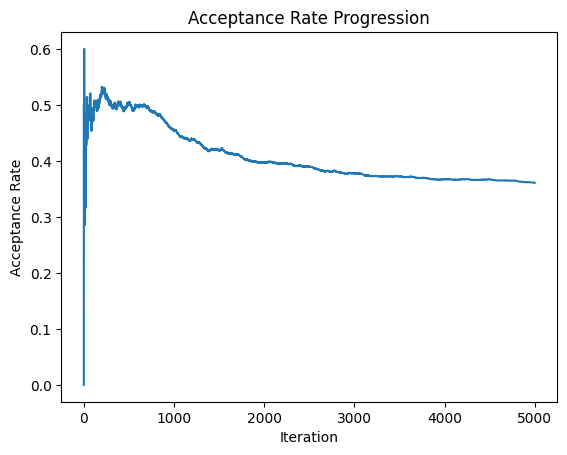

In [6]:
# Perform Gamma regression
print(f"[Info:] Performing Gamma Regression on 'NMHC(GT)'")
samples_gamma['NMHC(GT)'] = metropolis_gamma(y_gamma[:, 0], iterations=5000, step_alpha=0.008, step_beta=0.008)

[Info:] Performing Gamma Regression on 'NOx(GT)'


C:\Users\mahmu\AppData\Local\Temp\ipykernel_31184\4074450702.py:21: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(posterior_new - posterior_current)


Iteration 100: Acceptance Rate = 0.48
Iteration 200: Acceptance Rate = 0.51
Iteration 300: Acceptance Rate = 0.52
Iteration 400: Acceptance Rate = 0.50
Iteration 500: Acceptance Rate = 0.49
Iteration 600: Acceptance Rate = 0.49
Iteration 700: Acceptance Rate = 0.50
Iteration 800: Acceptance Rate = 0.50
Iteration 900: Acceptance Rate = 0.49
Iteration 1000: Acceptance Rate = 0.49
Iteration 1100: Acceptance Rate = 0.48
Iteration 1200: Acceptance Rate = 0.48
Iteration 1300: Acceptance Rate = 0.48
Iteration 1400: Acceptance Rate = 0.48
Iteration 1500: Acceptance Rate = 0.48
Iteration 1600: Acceptance Rate = 0.48
Iteration 1700: Acceptance Rate = 0.48
Iteration 1800: Acceptance Rate = 0.48
Iteration 1900: Acceptance Rate = 0.49
Iteration 2000: Acceptance Rate = 0.49
Iteration 2100: Acceptance Rate = 0.49
Iteration 2200: Acceptance Rate = 0.48
Iteration 2300: Acceptance Rate = 0.48
Iteration 2400: Acceptance Rate = 0.48
Iteration 2500: Acceptance Rate = 0.48
Iteration 2600: Acceptance Rate = 

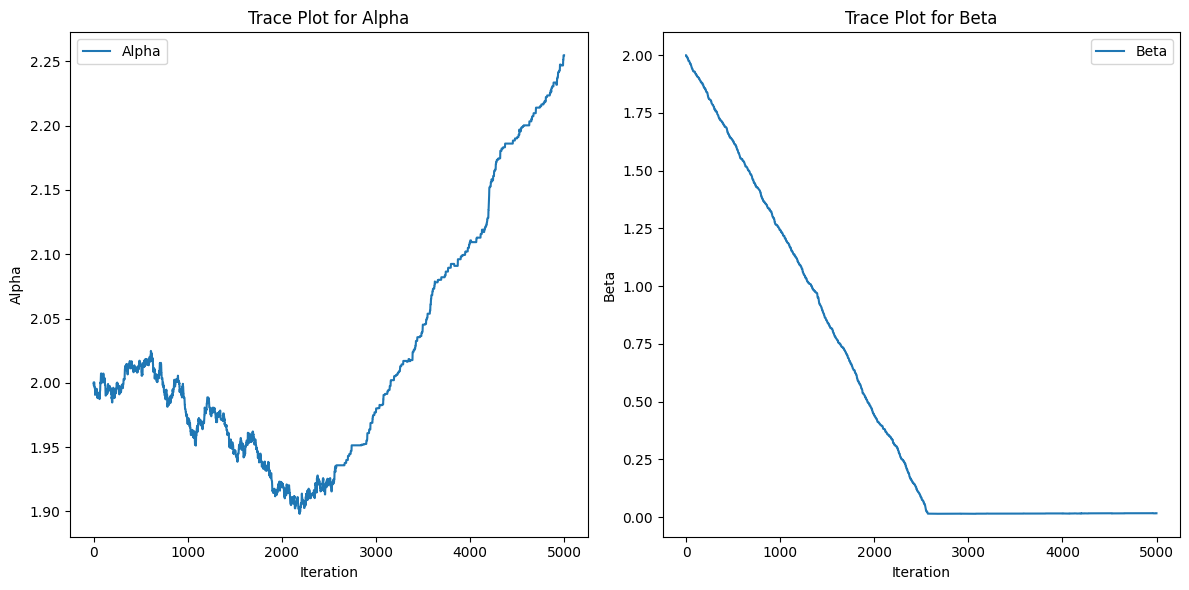

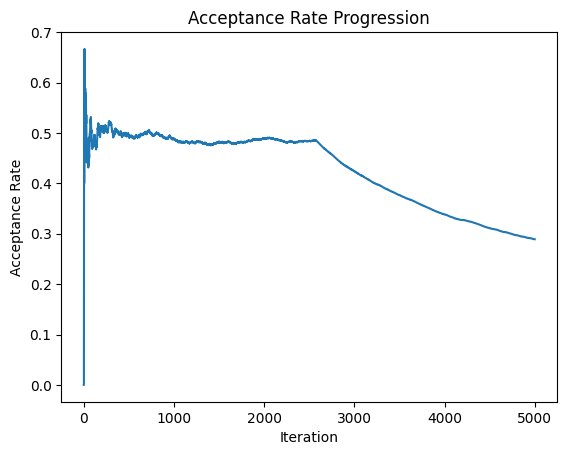

In [7]:
# Perform Gamma regression
print(f"[Info:] Performing Gamma Regression on 'NOx(GT)'")
samples_gamma['NOx(GT)'] = metropolis_gamma(y_gamma[:, 1], iterations=5000, step_alpha=0.002, step_beta=0.002)

In [8]:
# Linear Regression: Gibbs Sampling
def linear_posterior(beta, sigma2, X, y):
    residuals = y - X @ beta
    likelihood = -0.5 * len(y) * np.log(2 * np.pi * sigma2) - np.sum(residuals**2) / (2 * sigma2)
    prior_beta = -0.5 * np.sum(beta**2 / 10**2)  # Weak prior
    prior_sigma2 = -1.0 / sigma2  # Weak prior for sigma2
    return likelihood + prior_beta + prior_sigma2

def gibbs_linear(X, y, iterations=5000):
    N, p = X.shape
    beta = np.zeros(p)
    sigma2 = 1.0
    samples = []

    for _ in range(iterations):
        # Sample beta given sigma2
        Sigma_beta = np.linalg.inv(X.T @ X / sigma2 + np.eye(p) / 10**2)
        mu_beta = Sigma_beta @ (X.T @ y / sigma2)
        beta = np.random.multivariate_normal(mu_beta, Sigma_beta)

        # Sample sigma2 given beta
        residuals = y - X @ beta
        alpha_post = (N / 2) + 1
        beta_post = np.sum(residuals**2) / 2
        sigma2 = 1 / np.random.gamma(alpha_post, 1 / beta_post)

        samples.append((beta, sigma2))
    return samples

In [9]:
# Extract features for Linear regression
y_linear = data_transformed['CO(GT)'].values
X_linear = data_transformed[[
    'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
]].values

# Perform Linear regression
print("[Info:] Performing Linear Regression")
samples_linear = gibbs_linear(X_linear, y_linear)

[Info:] Performing Linear Regression


In [10]:
# Display results
print("Gamma Regression Samples:")
for feature, samples in samples_gamma.items():
    print(f"{feature}: Last 5 samples:")
    print(samples[-5:])

print("\nLinear Regression Samples:")
print("Last 5 samples of coefficients and sigma2:")
print(samples_linear[-5:])

Gamma Regression Samples:
NMHC(GT): Last 5 samples:
[[0.76880639 0.2627328 ]
 [0.77352171 0.26604914]
 [0.77352171 0.26604914]
 [0.77352171 0.26604914]
 [0.77593668 0.26625748]]
NOx(GT): Last 5 samples:
[[2.25467076 0.01669733]
 [2.25467076 0.01669733]
 [2.25467076 0.01669733]
 [2.25467076 0.01669733]
 [2.25467076 0.01669733]]

Linear Regression Samples:
Last 5 samples of coefficients and sigma2:
[(array([-0.127278  ,  0.07966657,  0.71152264,  0.01800881,  0.02152481]), 0.5355325745095084), (array([-0.14971094,  0.09134093,  0.7326787 ,  0.04264005,  0.01920067]), 0.524125139722469), (array([-0.09741769,  0.07880556,  0.70817663,  0.02512995, -0.00759922]), 0.5254610758949019), (array([-0.17668767,  0.08227128,  0.72824096,  0.06402102,  0.04250876]), 0.5433515133915182), (array([-0.18519207,  0.07774873,  0.72917297,  0.08443609,  0.02453391]), 0.5423278696143446)]
